In [17]:
%cd /content/drive/MyDrive/py_storage

from basic_preprocessing import *
from deeplearning_check import *


gpu_check()
# set_global_determinism(seed=SEED)

import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import glob
import math
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import Image

import tensorflow as tf
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import keras

#cv
import cv2
import math
from PIL import Image
import math
from scipy import ndimage
import argparse
import imutils
import xml.etree.ElementTree as ET

import random 
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.image as mpimg
from matplotlib import font_manager, rc
rc('font',family="consolas")
plt.rcParams["font.family"]="consolas" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="consolas", 
        rc={"axes.unicode_minus":False},style='darkgrid')

%cd C:\Users\yukir\Documents\Monicas_workspace\Knee

/content/drive/MyDrive/py_storage
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9875150587351031013
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14561217109921392998
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]
[Errno 2] No such file or directory: 'C:UsersyukirDocumentsMonicas_workspaceKnee'
/content/drive/MyDrive/py_storage


In [18]:
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()
    fig = plt.gcf()
    fig.savefig("../03_model_visualization/"+model_name+".jpg")
    plt.close(fig)

#### MODEL

In [23]:
def model():

    ### Input 1
    i_input = Input(shape = (224,224,3))
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input))
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))# 필터통과후에 피쳐맵이 작아지므로 padding으로 유지
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x) # 각 피처맵상의 노드값들의 평균값을 뽑아냄 ,1차원 벡터로 만듬
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,3)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(512,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output = Flatten()(pool4) # 완전 연결 네트워크에 연결하기 위해 1차원 배열로 변경

    i_model = Model(inputs = i_input, outputs = i_output)

    ######################### mask_img ########################

    i_input1 = Input(shape = (224,224,3))
    
    #block 1
    conv1 = ReLU()(Conv2D(32,3)(i_input1)) 
    conv2 = ReLU()(Conv2D(32,3)(conv1))
    conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2)) 
    x = Conv2D(64,1)(conv3)
    x = BatchNormalization()(x)

    se = GlobalAveragePooling2D()(x)
    se = Dense(4,activation="relu")(se)
    se = Dense(64,activation="relu")(se)
    se = Reshape([1,1,64])(se)
    x = Multiply()([conv3,se])

    short = Conv2D(64,(1,1))(conv2)
    short = BatchNormalization()(short)

    x = ReLU()(add([x,short]))

    pool1 = MaxPool2D(pool_size=(2,2))(x)
    #block 2
    conv4 = ReLU()(Conv2D(60,3)(pool1))
    conv5 = ReLU()(Conv2D(192,3)(conv4))
    pool2 = MaxPool2D(pool_size=(2,2))(conv5)
    #block 3
    conv6 = ReLU()(Conv2D(256,3)(pool2))
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    #block 4
    conv7 = ReLU()(Conv2D(512,3,padding='same')(pool3)) # 반으로 줄임
    pool4 = MaxPool2D(pool_size=(2,2))(conv7)
    i_output1 = Flatten()(pool4)

    i_model1 = Model(inputs = i_input1, outputs = i_output1)

    #########################    grade            #######################
    # g_input = Input(shape = (1,))
    # g_output = Dense(64,activation="relu")(g_input)
    # g_model = Model(inputs = g_input,outputs = g_output)


    ########################   concat   ###################
    con1 = concatenate([i_model.output,i_model1.output])
    dense1 = ReLU()(Dense(1024)(con1)) # dense1,2,3을 다 반으로 변경
    # con2 = concatenate([dense1,g_model.output])
    dense2 = ReLU()(Dense(512)(dense1))
    dense3 = ReLU()(Dense(256)(dense2))
    model_out = Dense(5,activation = "softmax")(dense3) ###여기서 문제 발생?, g_model하고 

    model = Model([i_model.input, i_model1.input],[model_out])
    return model

https://jsc5565.tistory.com/12

In [24]:
model_name = "arth_model"
model_weight = model_name +"_weight.h5"

model = model()
model.save(model_name+".h5")
model.compile(loss ='categorical_crossentropy', optimizer= 'Adam', metrics = ["acc"] )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [25]:
model.input

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_4')>]

In [27]:
%cd /content/drive/MyDrive/Projects/knee

/content/drive/MyDrive/Projects/knee


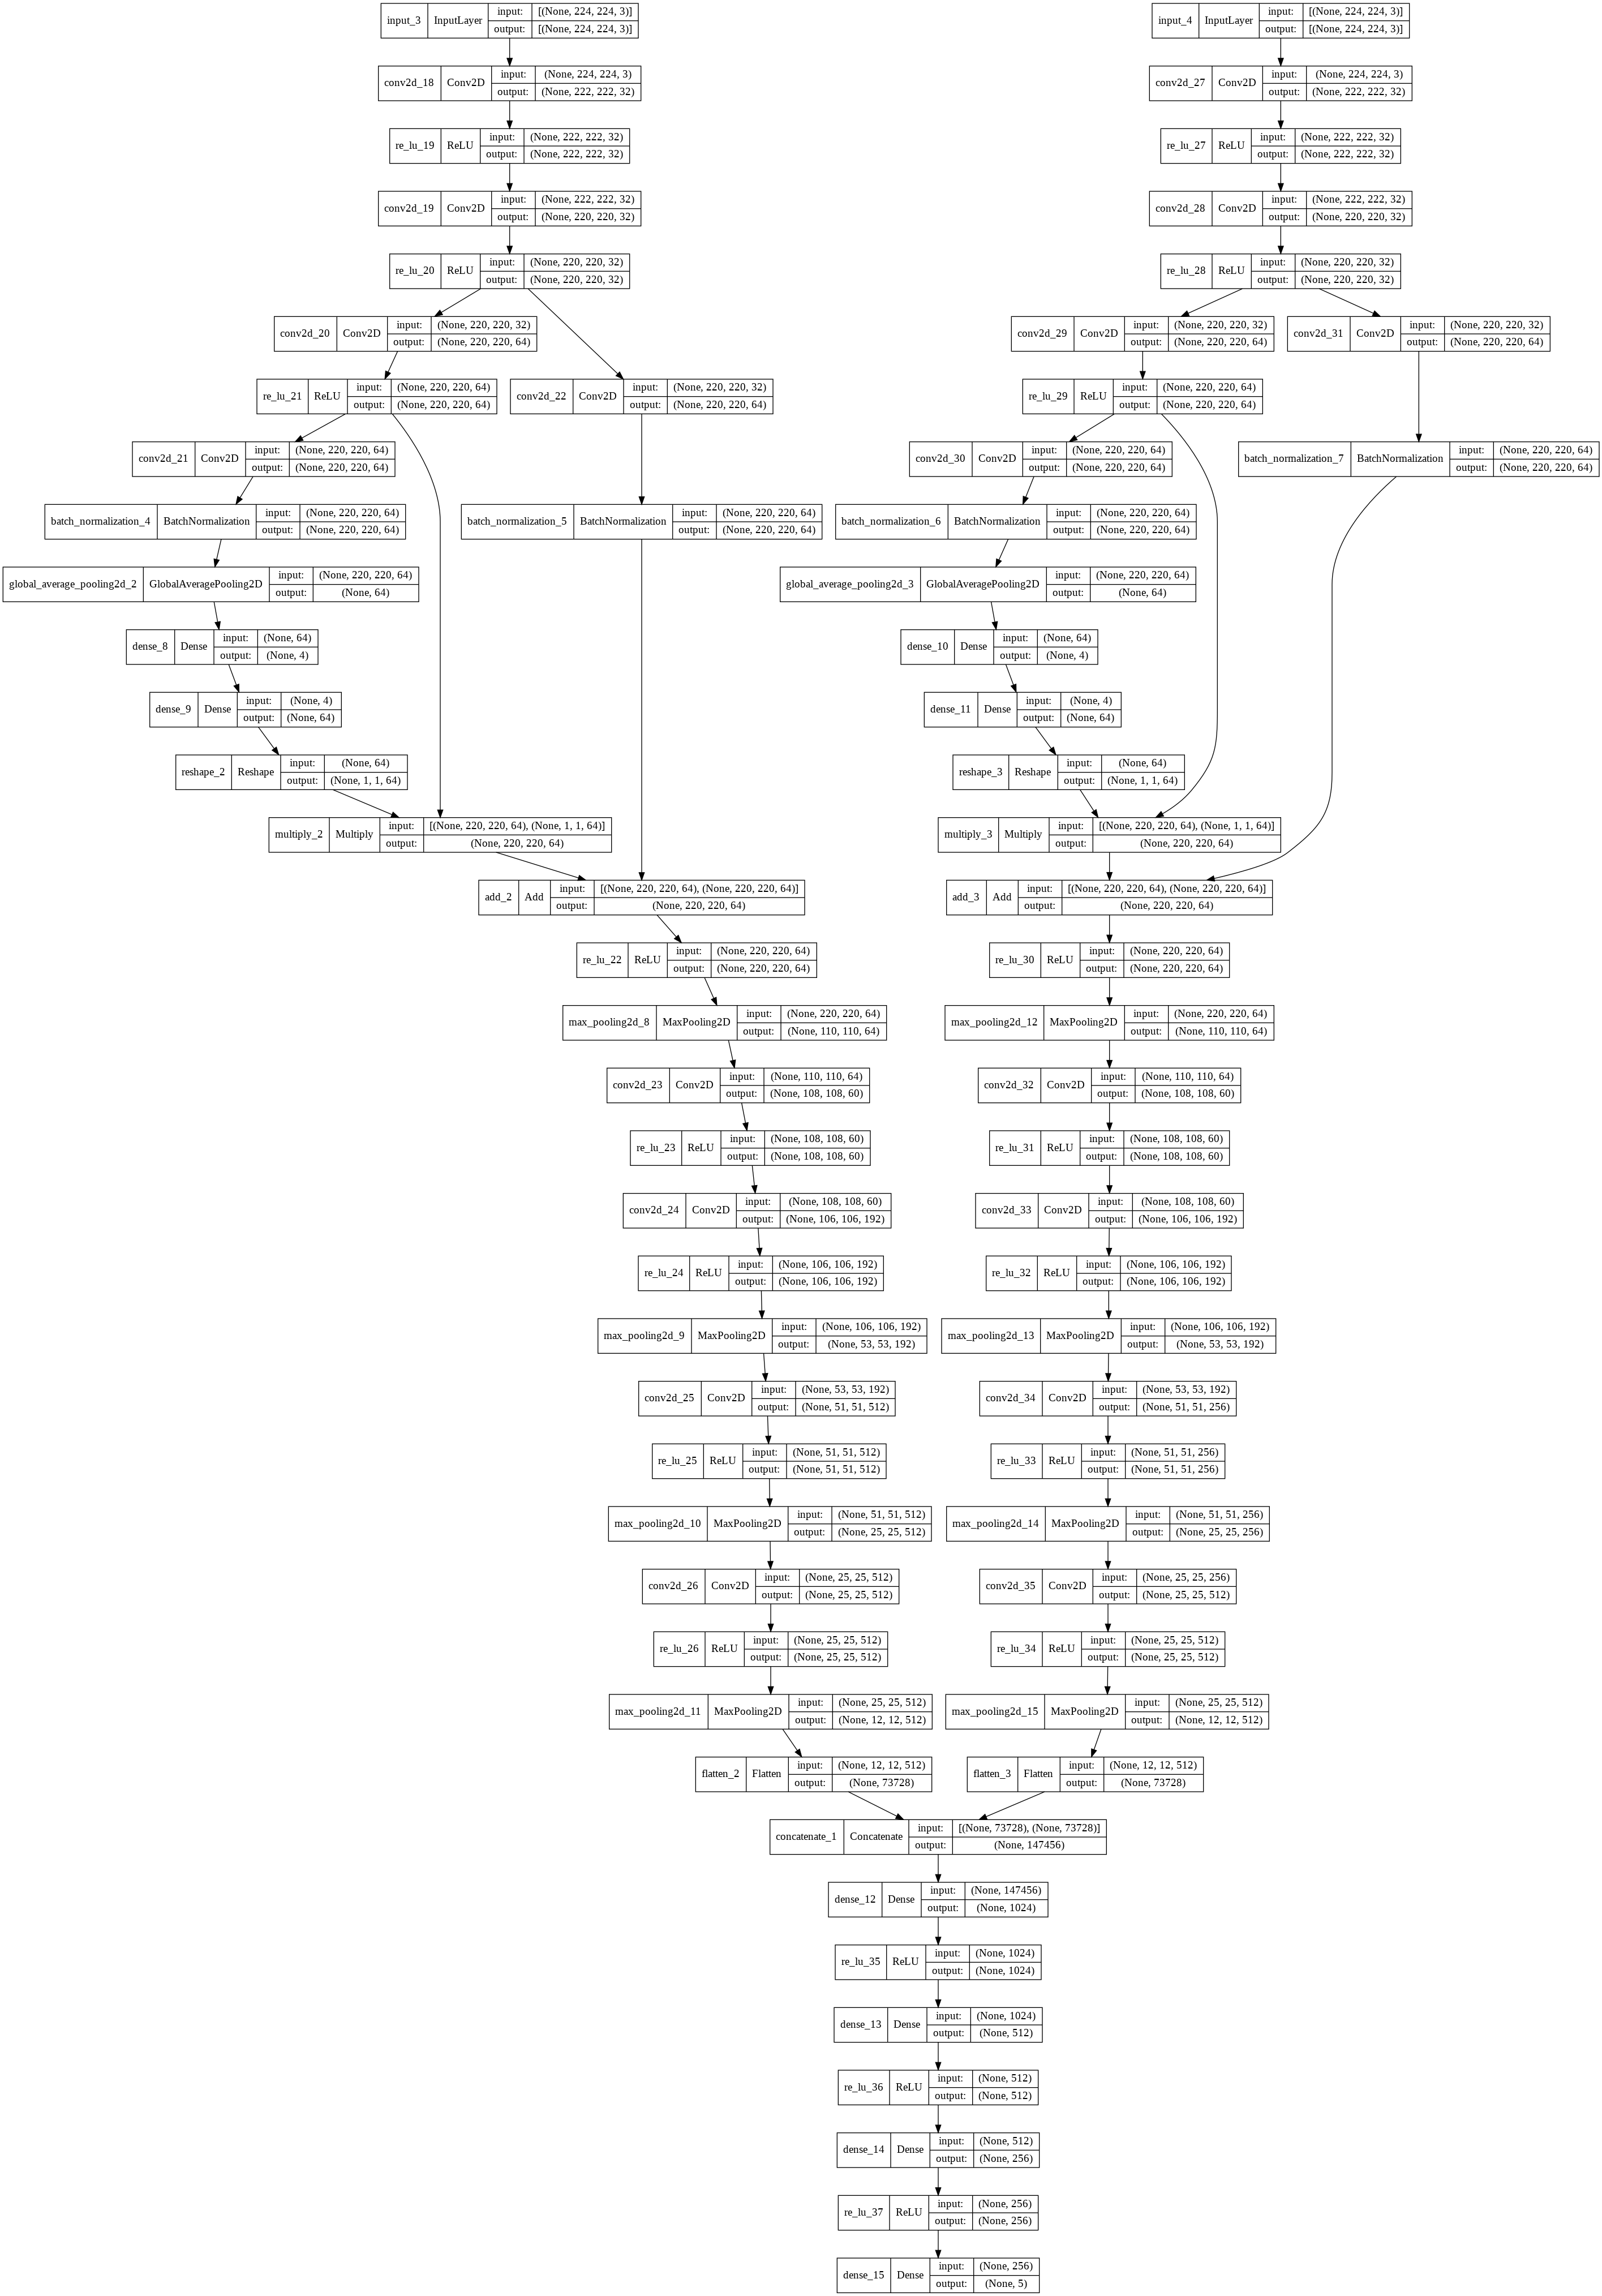

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)